In [1]:
from torch.utils.data import DataLoader
import torch
import numpy as np
from nbeats_pytorch.model import NBeatsNet as NBeatsNet
from torch.nn import functional as F
import pandas as pd
import matplotlib.pyplot as plt
from torch import optim
import warnings
import pickle
import os
warnings.filterwarnings("ignore" , message="Setting Attributes")

# Define save function ourselves
def save(model, filepath):
    """Save model to filepath"""
    dirname = os.path.dirname(filepath)
    if dirname:  # ถ้ามี directory path
        os.makedirs(dirname, exist_ok=True)
    torch.save(model.state_dict(), filepath)

In [2]:
def plot_scatter(*args, **kwargs):
    plt.plot(*args, **kwargs)
    plt.scatter(*args, **kwargs)

# Configuration parameters
forecast_length = 90
backcast_length = 4 * forecast_length
batch_size = 16

def data_generator(x, y, size):
    assert len(x) == len(y), "Input and output data must have the same length"
    batches = []
    for ii in range(0, len(x), size):
        batches.append((x[ii:ii+size], y[ii:ii+size]))
    for batch in batches:
        yield batch

In [4]:
transport_data = pd.read_csv('../../data/data_adjustmented.csv', parse_dates=['วันที่'])
data = transport_data['รถไฟฟ้าสายสีน้ำเงิน'].values.flatten()  # Use .flatten() to convert to 1D
data

array([236053, 341059, 373005, ..., 488170, 510420, 520075], dtype=int64)

Generated 1623 samples
Train samples: 1298, Test samples: 325
Normalization constant: 555976
| N-Beats
| --  Stack Generic (#0) (share_weights_in_stack=False)
     | -- GenericBlock(units=128, thetas_dim=4, backcast_length=360, forecast_length=90, share_thetas=False) at @1796479671216
     | -- GenericBlock(units=128, thetas_dim=4, backcast_length=360, forecast_length=90, share_thetas=False) at @1796479670928
     | -- GenericBlock(units=128, thetas_dim=4, backcast_length=360, forecast_length=90, share_thetas=False) at @1796479667952
| --  Stack Generic (#1) (share_weights_in_stack=False)
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=360, forecast_length=90, share_thetas=False) at @1796479667904
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=360, forecast_length=90, share_thetas=False) at @1796479668336
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=360, forecast_length=90, share_thetas=False) at @1796479664592


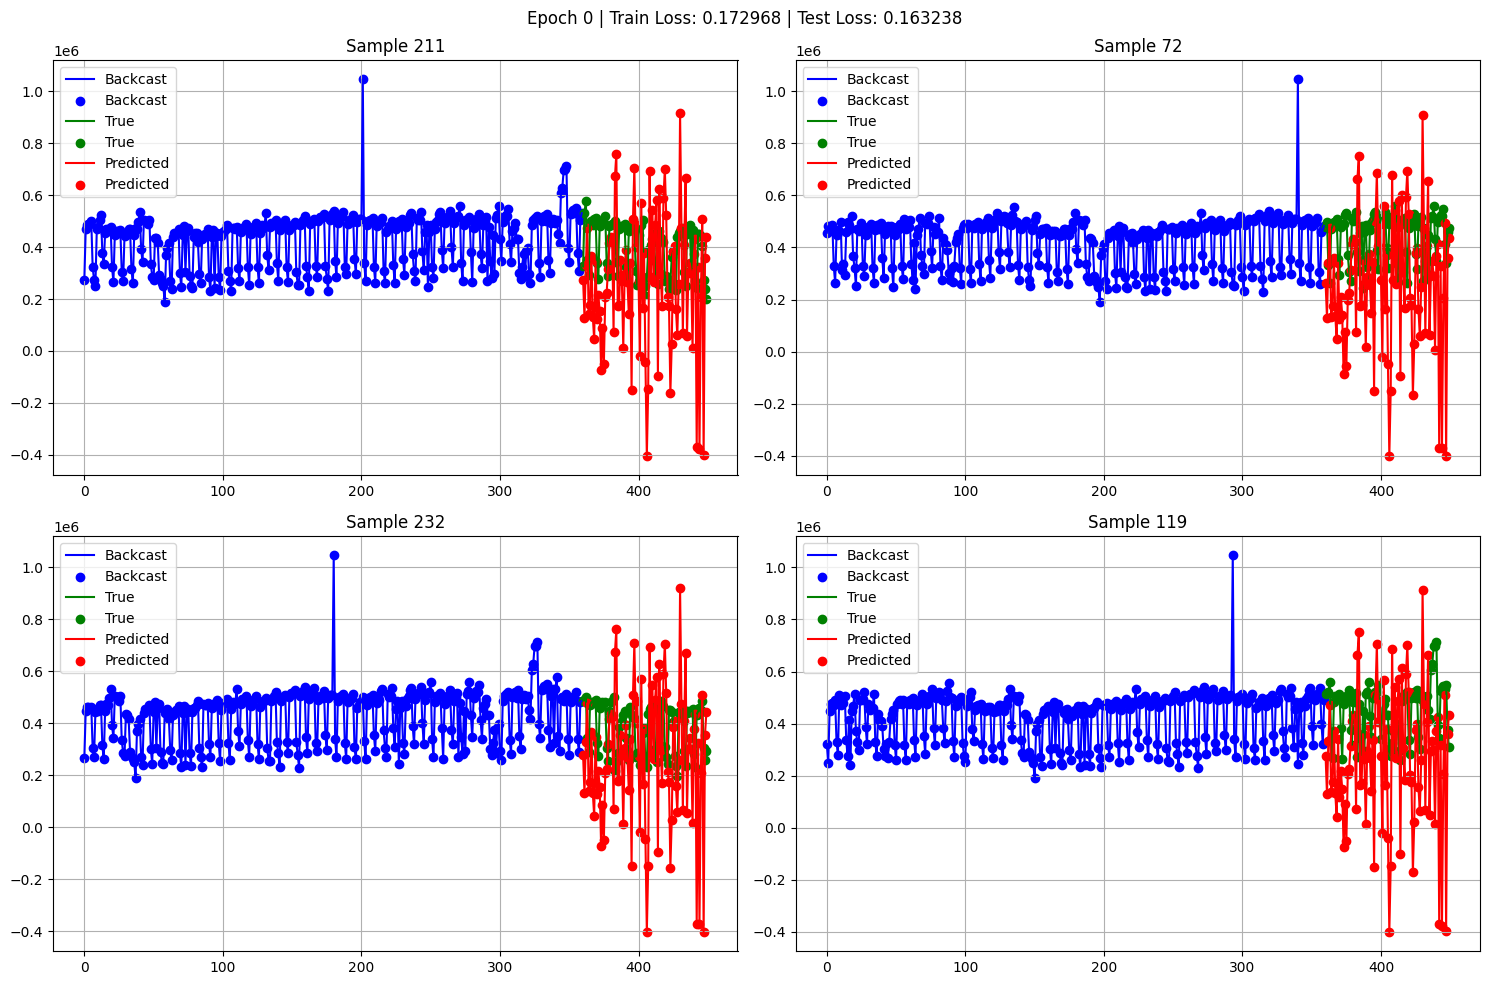

epoch = 0000, grad_step = 000082, train_loss = 172.968, test_loss = 163.238, best_test_loss = 163.238


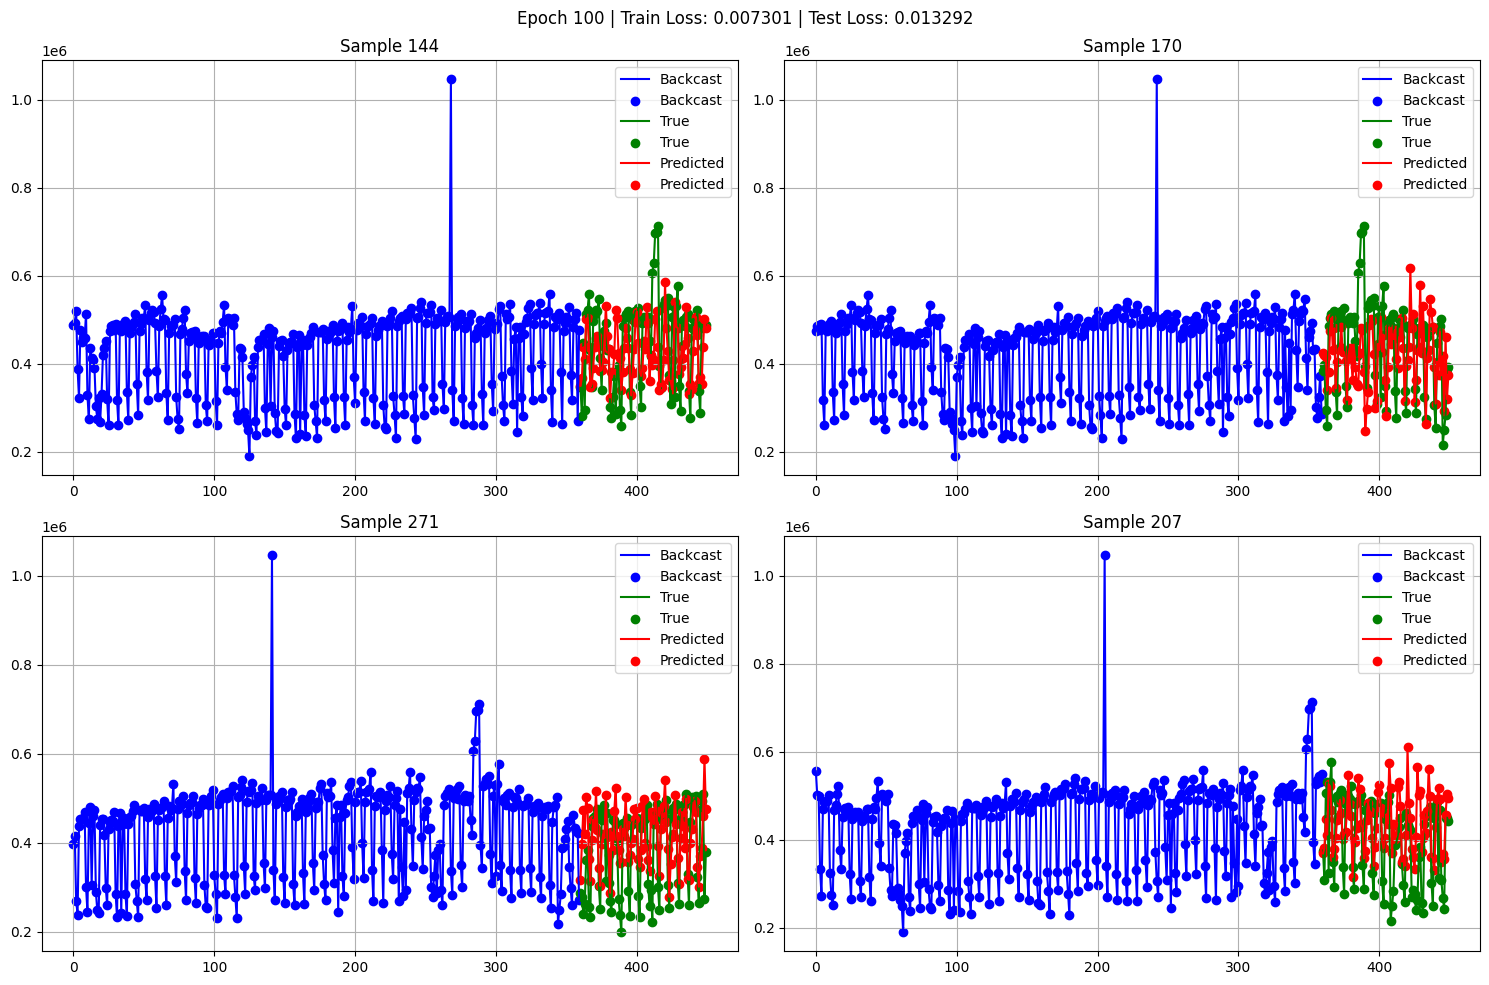

epoch = 0100, grad_step = 008282, train_loss = 7.301, test_loss = 13.292, best_test_loss = 13.292


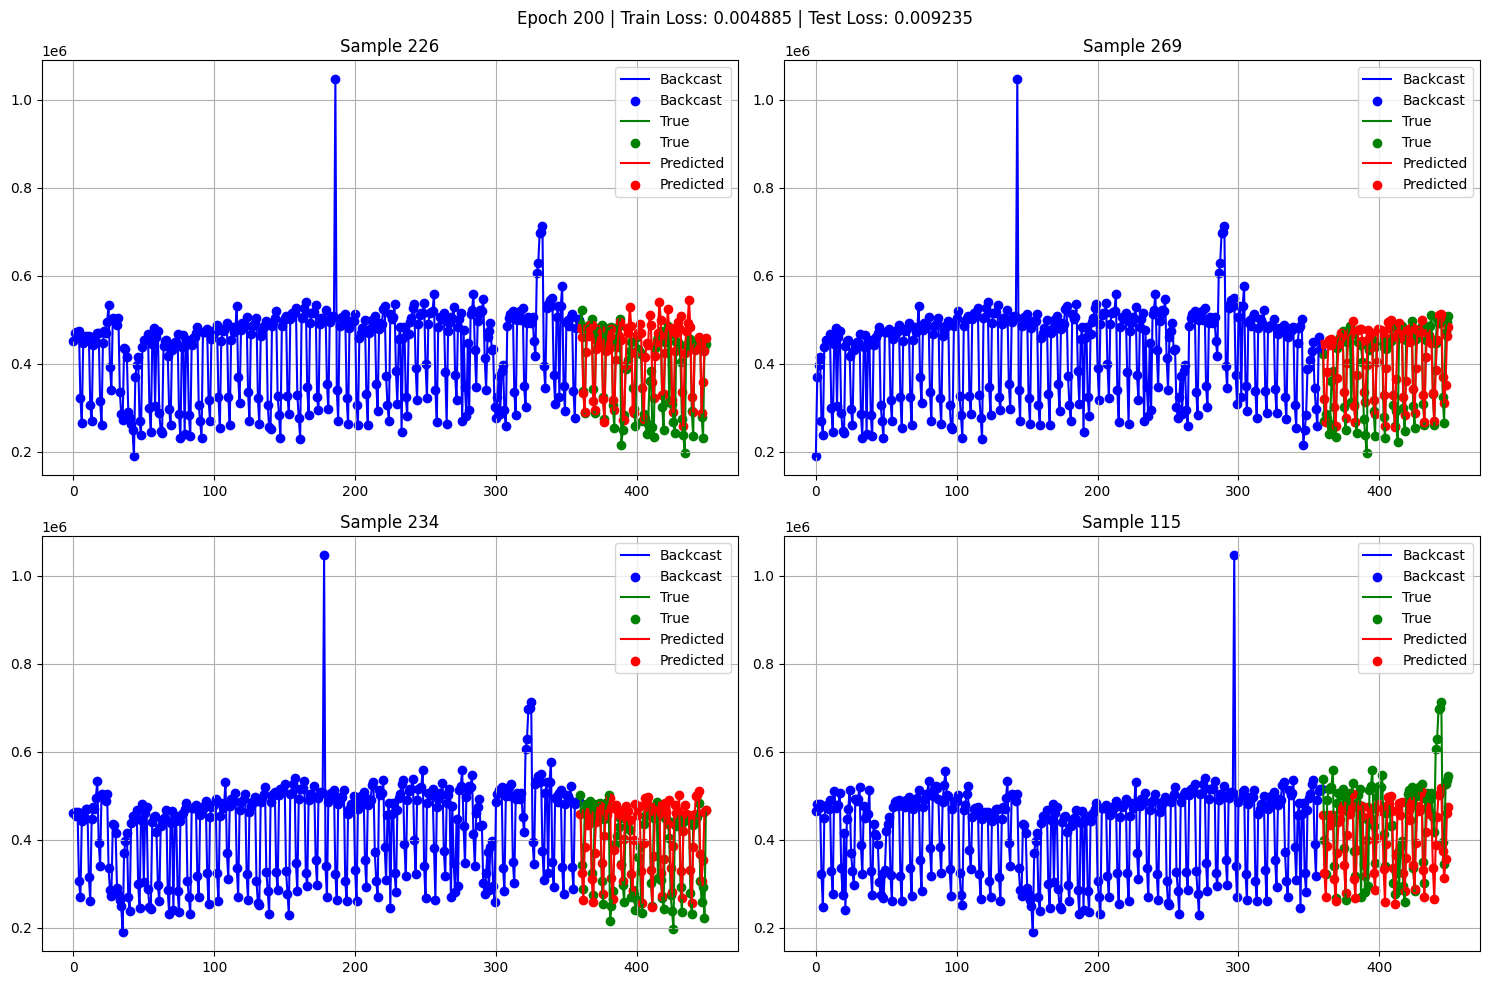

epoch = 0200, grad_step = 016482, train_loss = 4.885, test_loss = 9.235, best_test_loss = 9.053


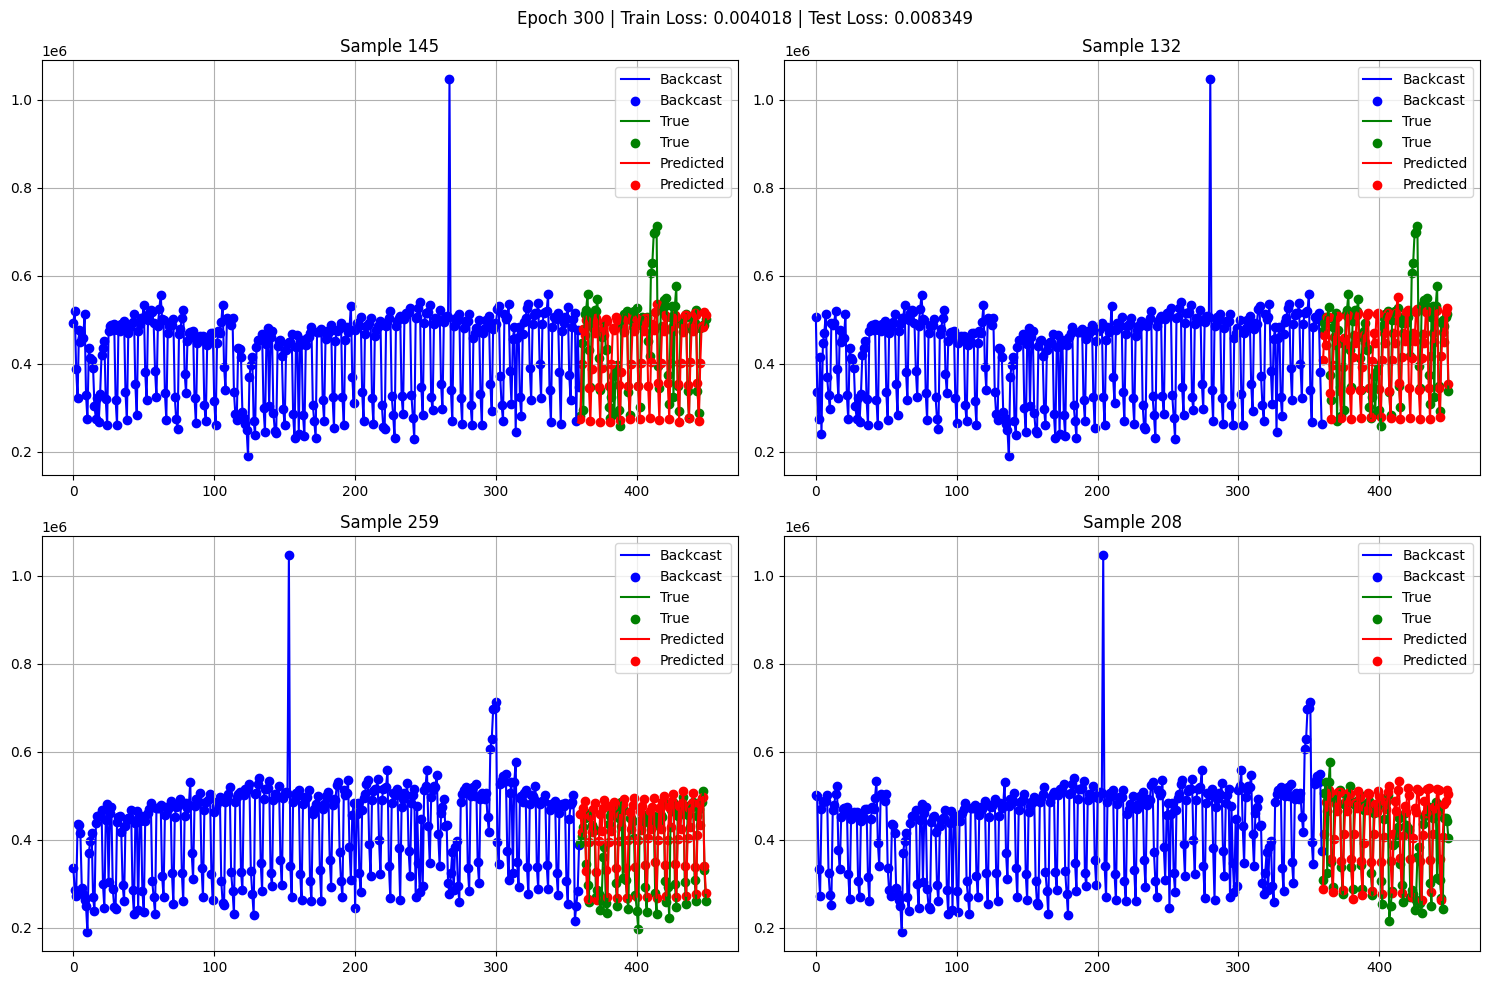

epoch = 0300, grad_step = 024682, train_loss = 4.018, test_loss = 8.349, best_test_loss = 8.283


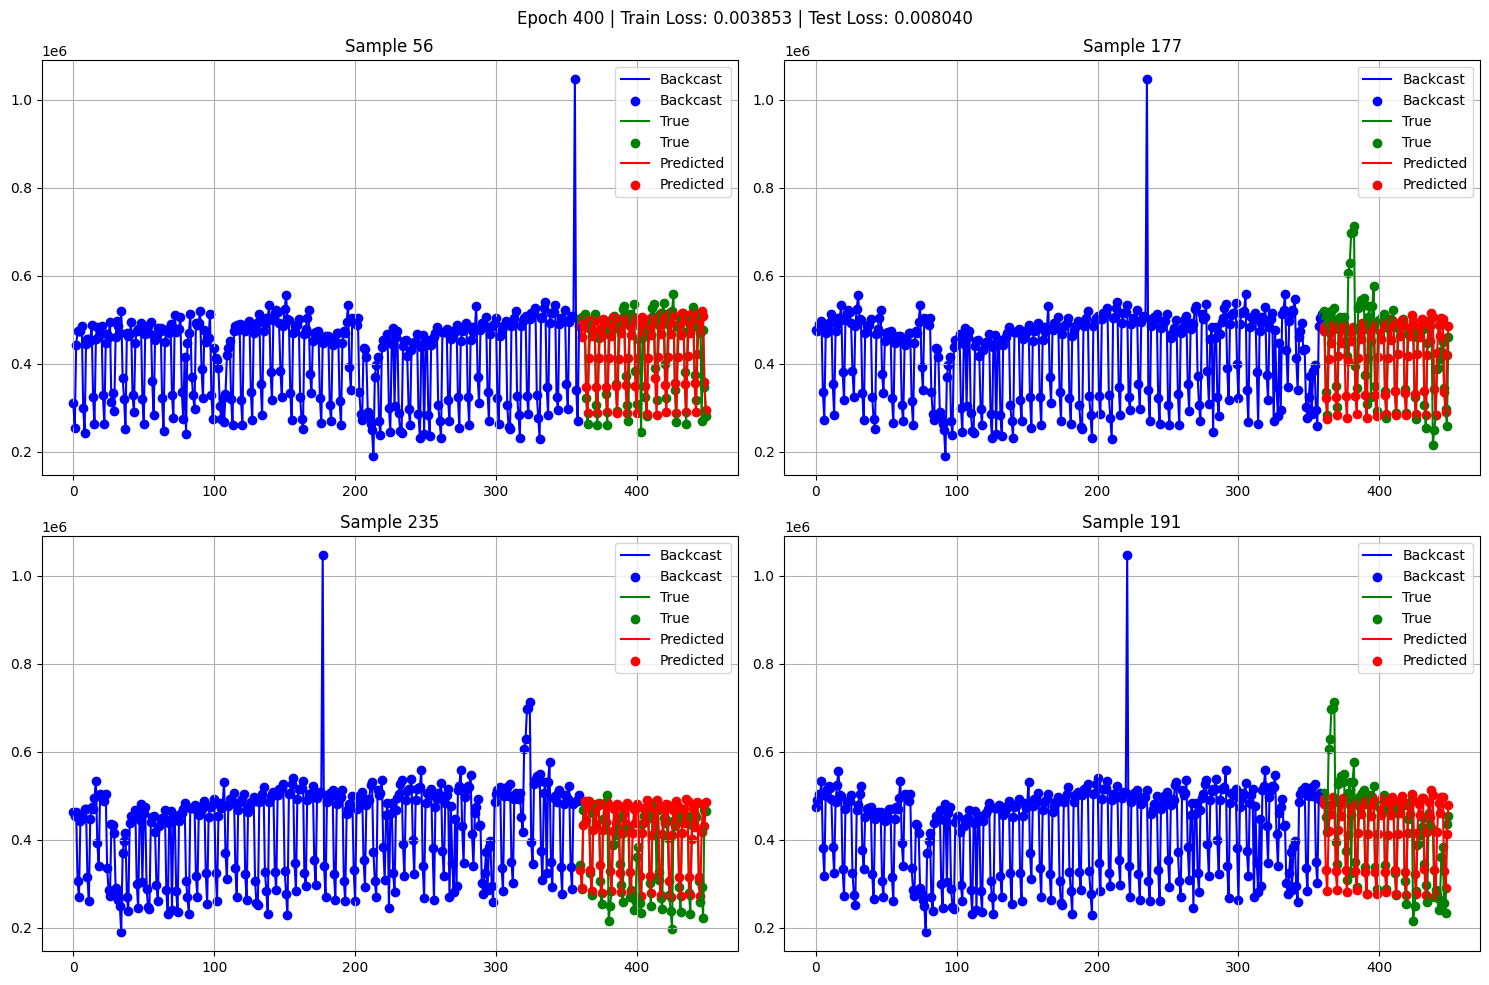

epoch = 0400, grad_step = 032882, train_loss = 3.853, test_loss = 8.040, best_test_loss = 7.988


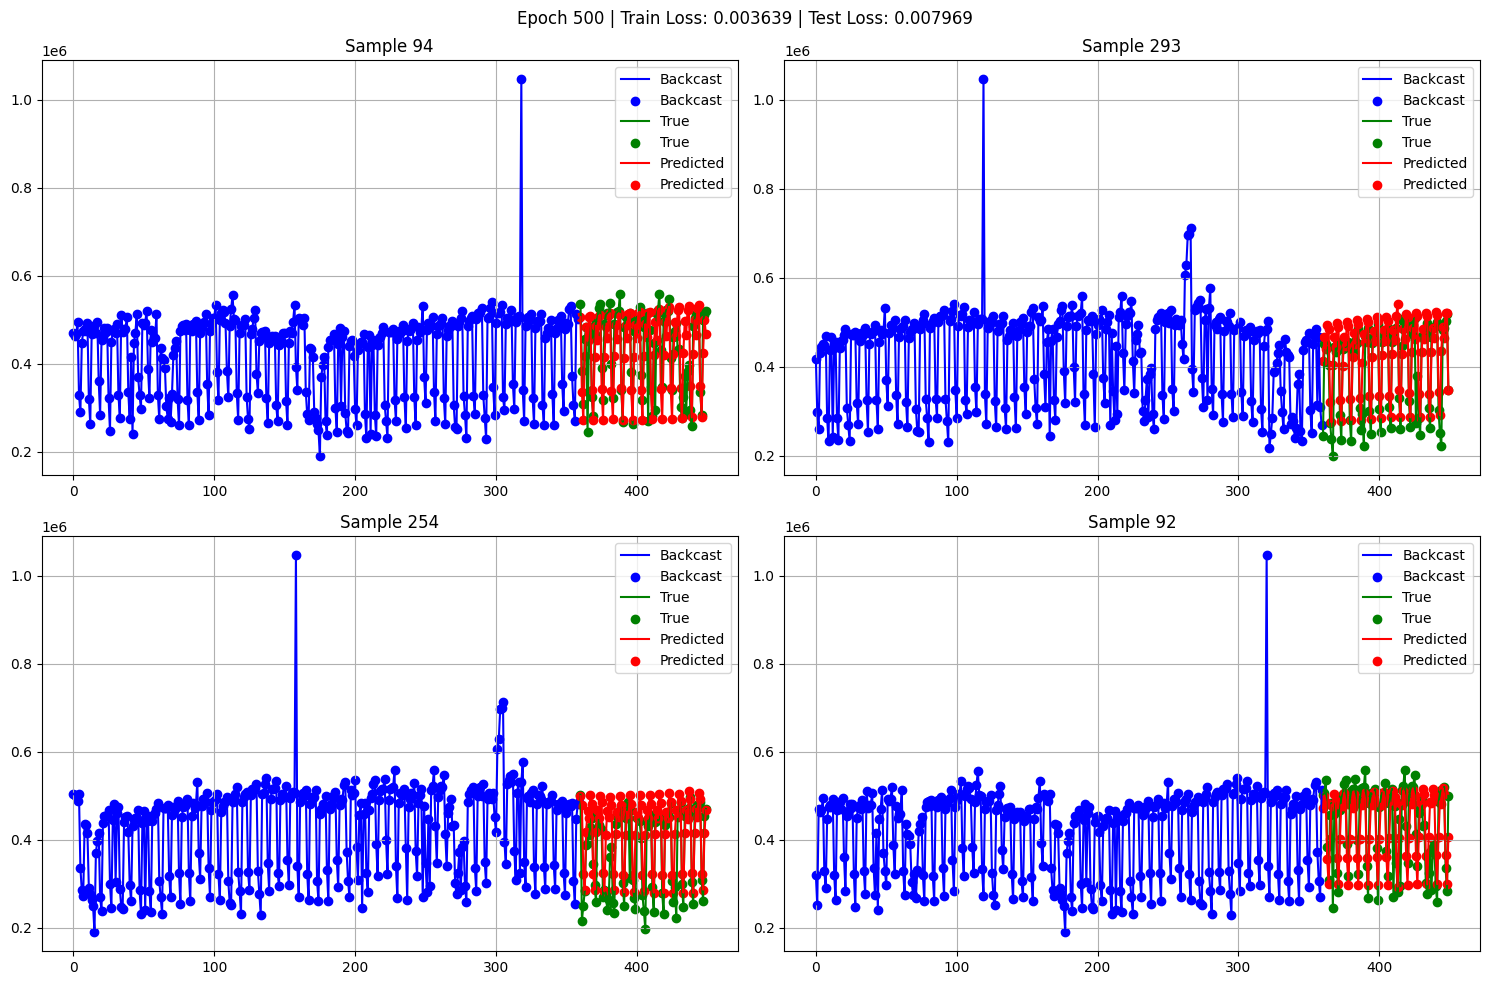

epoch = 0500, grad_step = 041082, train_loss = 3.639, test_loss = 7.969, best_test_loss = 7.910


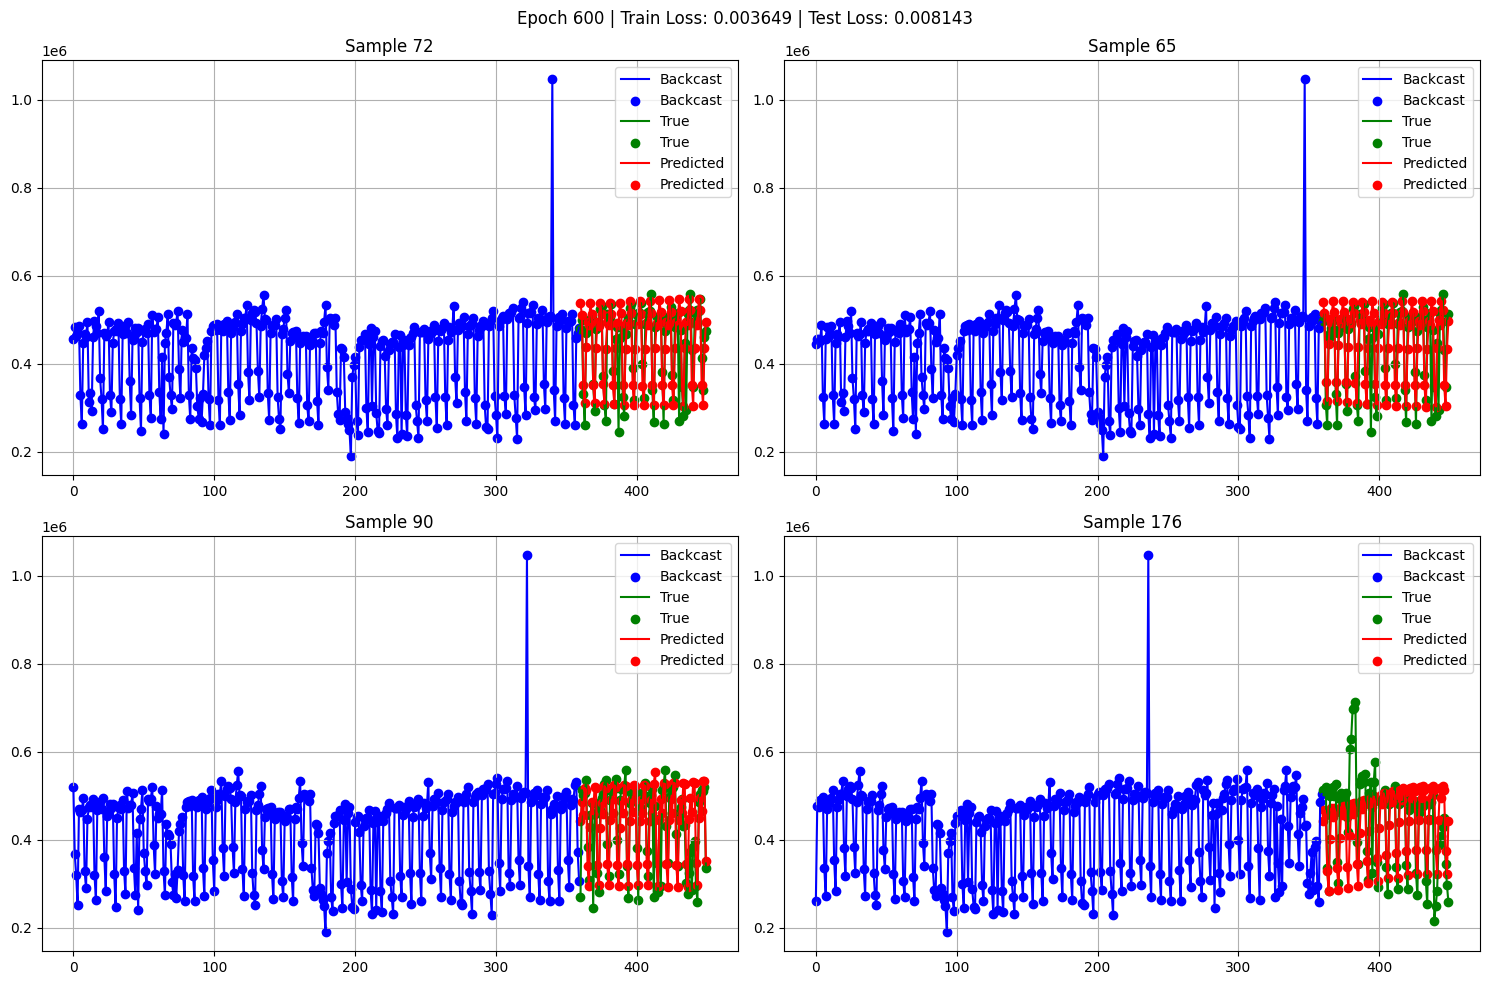

epoch = 0600, grad_step = 049282, train_loss = 3.649, test_loss = 8.143, best_test_loss = 7.893


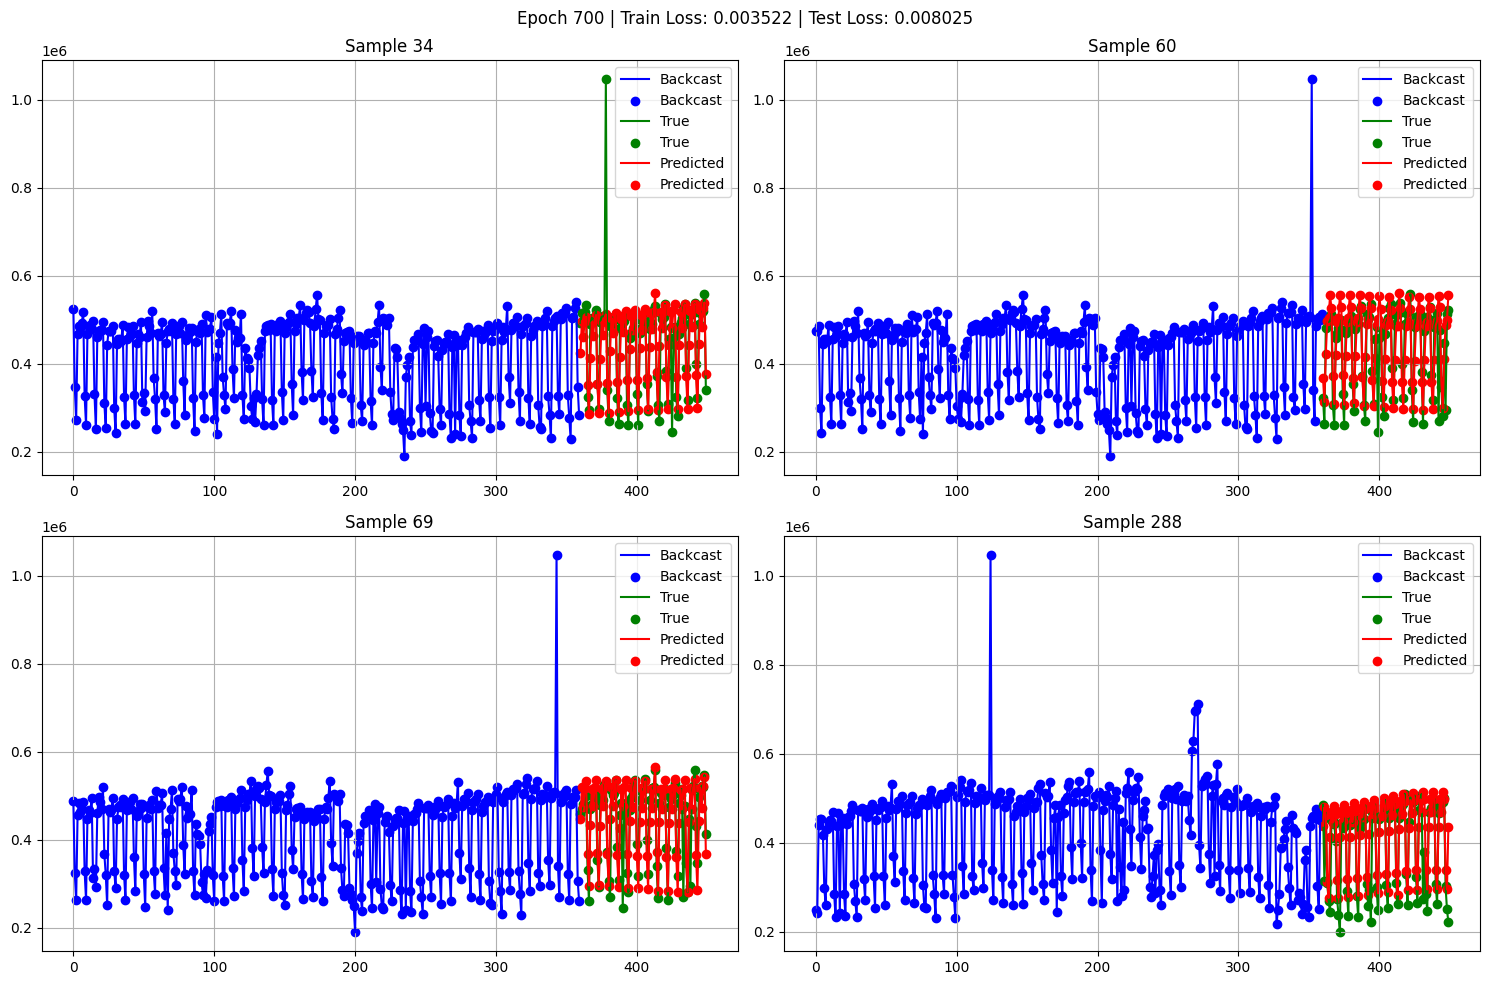

epoch = 0700, grad_step = 057482, train_loss = 3.522, test_loss = 8.025, best_test_loss = 7.893


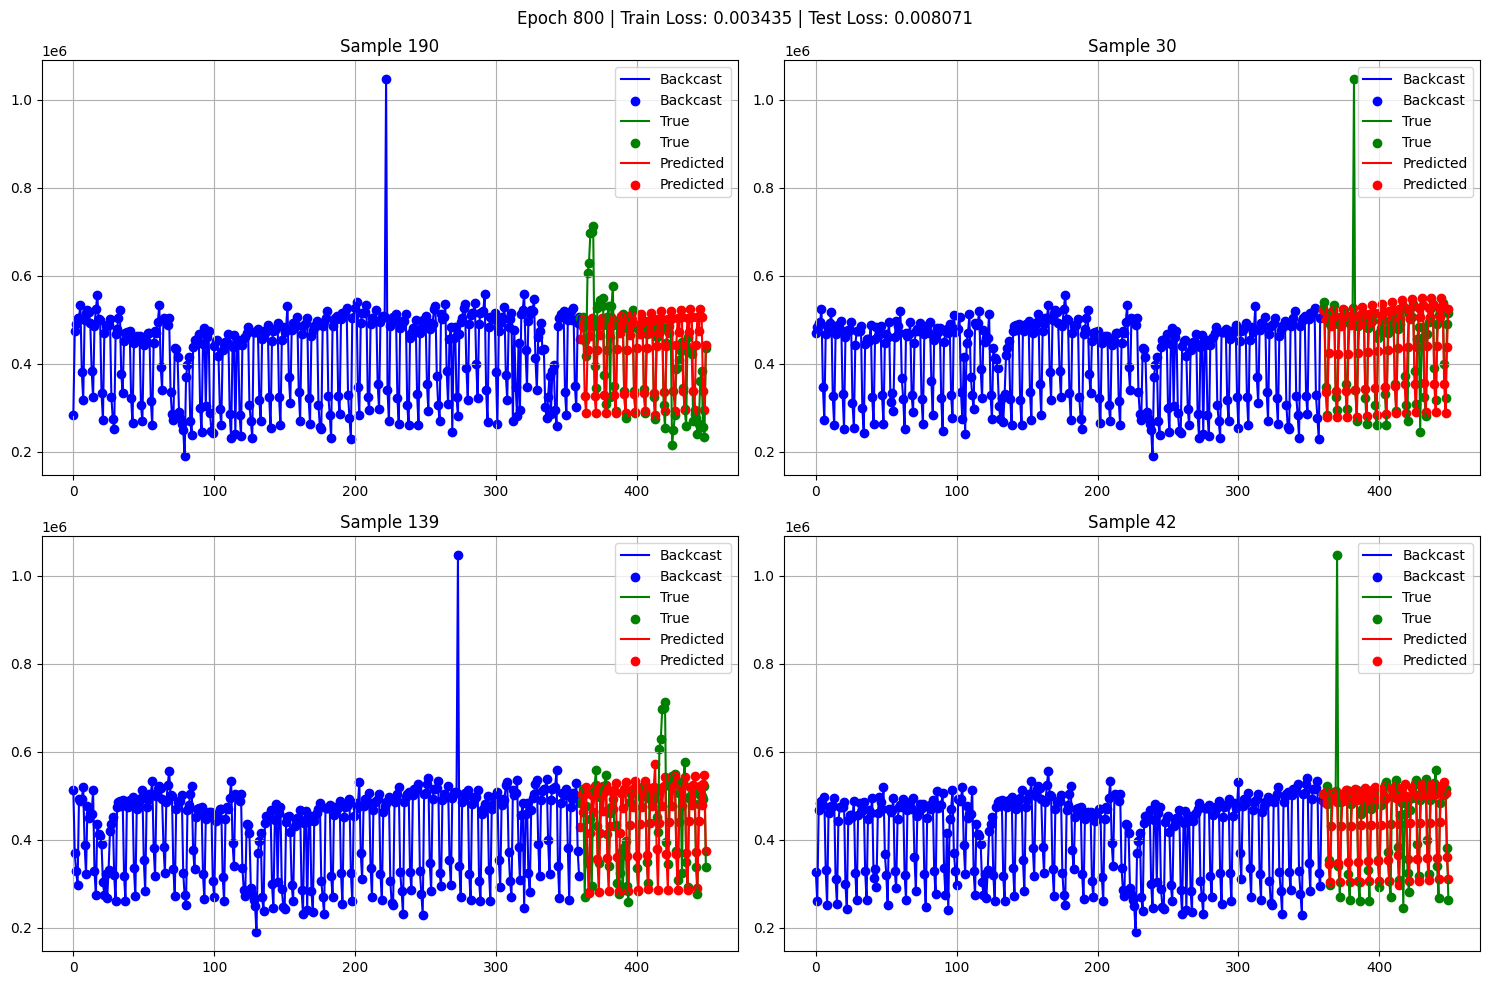

epoch = 0800, grad_step = 065682, train_loss = 3.435, test_loss = 8.071, best_test_loss = 7.893


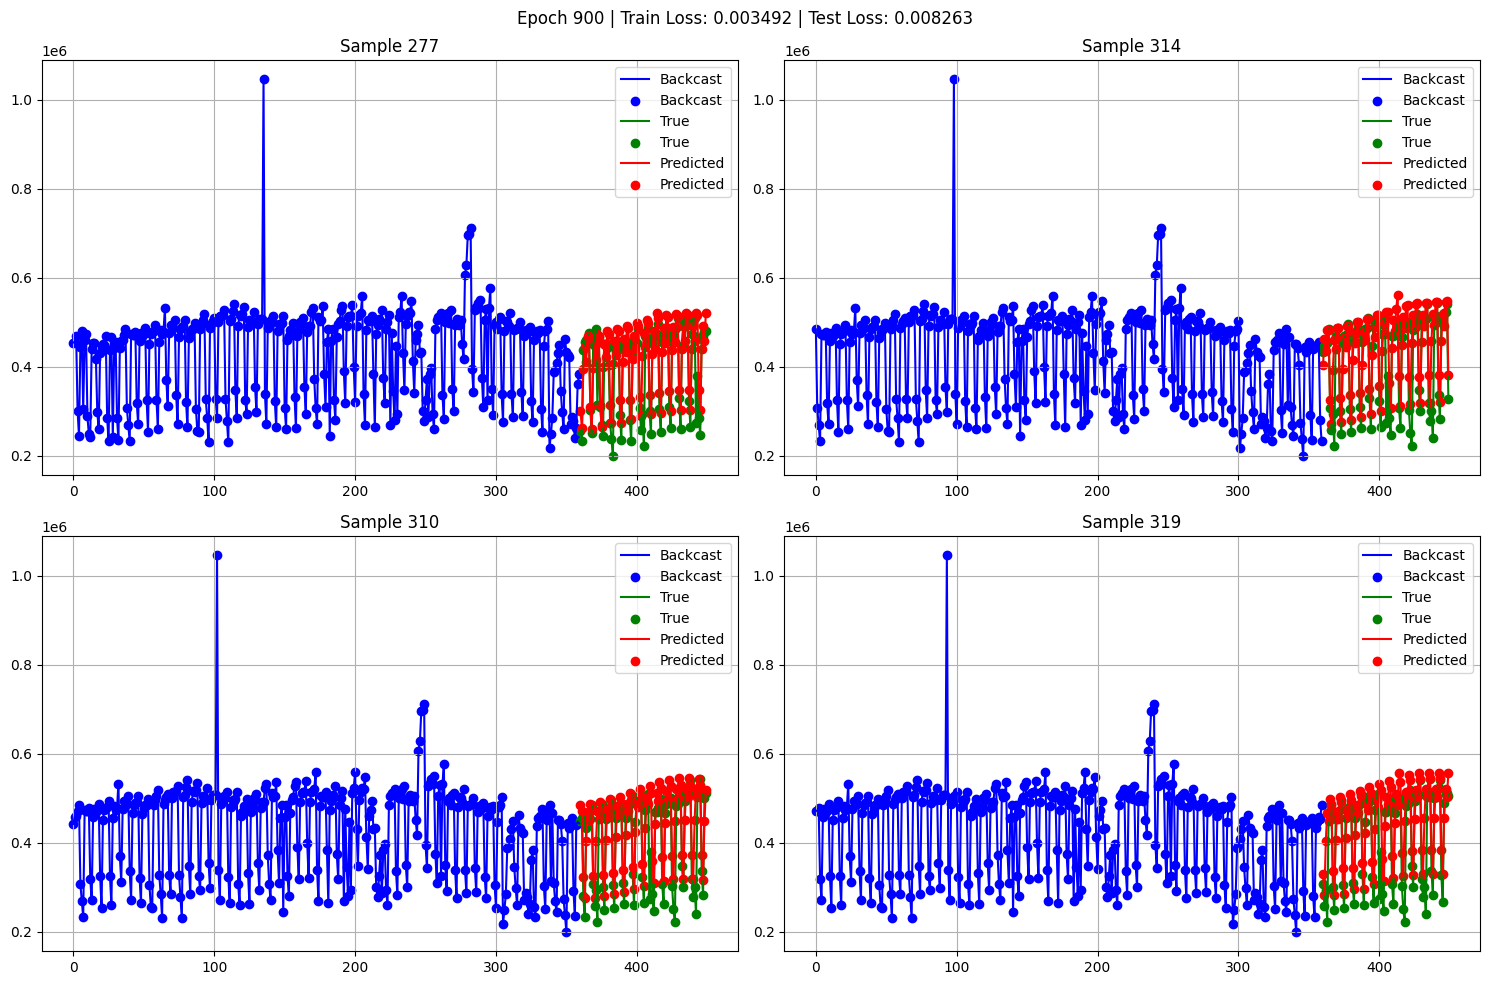

epoch = 0900, grad_step = 073882, train_loss = 3.492, test_loss = 8.263, best_test_loss = 7.874
Training completed!
Best test loss: 7.782
Training completed!
Best test loss: 7.782


In [14]:
def train():
    # ใช้ global variables แทนการ redefine
    global forecast_length, backcast_length, batch_size, data
    
    
    # data backcast/forecast generation - แก้ไขการใช้ epoch ซ้ำ
    x, y = [], []
    for i in range(backcast_length, len(data) - forecast_length):
        x.append(data[i - backcast_length:i])
        y.append(data[i:i + forecast_length])
    x = np.array(x)
    y = np.array(y)
    
    print(f"Generated {len(x)} samples")

    # split train/test - แก้ไขการแบ่งข้อมูล
    c = int(len(x) * 0.8)
    x_train, y_train = x[:c], y[:c]
    x_test, y_test = x[c:], y[c:]
    
    print(f"Train samples: {len(x_train)}, Test samples: {len(x_test)}")

    # normalization
    norm_constant = np.max(x_train)
    x_train, y_train = x_train / norm_constant, y_train / norm_constant
    x_test, y_test = x_test / norm_constant, y_test / norm_constant
    
    print(f"Normalization constant: {norm_constant}")

    # model - แก้ไข: ใช้ 2 stacks แทน 3 เพื่อหลีกเลี่ยง IndexError
    net = NBeatsNet(
        stack_types=(NBeatsNet.GENERIC_BLOCK, NBeatsNet.GENERIC_BLOCK),
        forecast_length=forecast_length,
        backcast_length=backcast_length,
        hidden_layer_units=128,
        nb_blocks_per_stack=3  # เพิ่มจำนวน blocks ต่อ stack แทน
    )
    
    
    # แก้ไข learning rate และเพิ่ม weight decay
    optimiser = optim.Adam(params=net.parameters(), lr=1e-4, weight_decay=1e-4)

    grad_step = 0
    best_test_loss = float('inf')
    
    for epoch in range(1000):
        # train
        net.train()
        train_loss = []
        
        for x_train_batch, y_train_batch in data_generator(x_train, y_train, batch_size):
            grad_step += 1
            optimiser.zero_grad()
            _, forecast = net(torch.tensor(x_train_batch, dtype=torch.float).to(net.device))
            loss = F.huber_loss(forecast, torch.tensor(y_train_batch, dtype=torch.float).to(net.device), delta=1.0)
            train_loss.append(loss.item())
            loss.backward()
            
            # Gradient clipping เพื่อป้องกัน exploding gradients
            torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=1.0)
            
            optimiser.step()
            
        train_loss = np.mean(train_loss)

        # test
        net.eval()
        with torch.no_grad():  # เพิ่ม no_grad เพื่อประหยัด memory
    
            _, forecast = net(torch.tensor(x_test, dtype=torch.float).to(net.device))
            test_loss = F.huber_loss(forecast, torch.tensor(y_test, dtype=torch.float) , delta = 1.0).item()
            p = forecast.detach().cpu().numpy()  # ย้ายกลับ CPU
        
        # Save best model
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            save(net, f'best_model.pth')
            
        if epoch % 100 == 0:
            subplots = [221, 222, 223, 224]
            plt.figure(figsize=(15, 10))
            
            # ตรวจสอบว่ามีข้อมูลพอสำหรับ visualization
            n_samples = min(4, len(x_test))
            indices = np.random.choice(range(len(x_test)), size=n_samples, replace=False)
            
            for plot_id, i in enumerate(indices):
                ff, xx, yy = p[i] * norm_constant, x_test[i] * norm_constant, y_test[i] * norm_constant
                plt.subplot(subplots[plot_id])
                plt.grid()
                plot_scatter(range(0, backcast_length), xx, label='Backcast', color='blue')
                plot_scatter(range(backcast_length, backcast_length + forecast_length), yy, label='True', color='green')
                plot_scatter(range(backcast_length, backcast_length + forecast_length), ff, label='Predicted', color='red')
                plt.legend()
                plt.title(f'Sample {i}')
            
            plt.suptitle(f'Epoch {epoch} | Train Loss: {train_loss:.6f} | Test Loss: {test_loss:.6f}')
            plt.tight_layout()
            plt.show()

            # แก้ไขการ save - ใช้ model เท่านั้น
            save(net, f'model_epoch_{epoch}.pth')
            print(f'epoch = {str(epoch).zfill(4)}, '
                  f'grad_step = {str(grad_step).zfill(6)}, '
                  f'train_loss = {1000 * train_loss:.3f}, '
                  f'test_loss = {1000 * test_loss:.3f}, '
                  f'best_test_loss = {1000 * best_test_loss:.3f}')

    print("Training completed!")
    print(f"Best test loss: {1000 * best_test_loss:.3f}")

# เรียกใช้ function
if __name__ == "__main__":
    train()

In [5]:
def load_model(model_path='best_model.pth'):
    """โหลดโมเดลที่ฝึกแล้ว"""
    global forecast_length , backcast_length
    net = NBeatsNet(
        stack_types=(NBeatsNet.GENERIC_BLOCK, NBeatsNet.GENERIC_BLOCK),
        forecast_length= forecast_length,
        backcast_length= backcast_length,
        hidden_layer_units=128,
        nb_blocks_per_stack=3
    )
    
    # ตรวจสอบว่าไฟล์โมเดลมีอยู่หรือไม่
    if os.path.exists(model_path):
        net.load_state_dict(torch.load(model_path, map_location='cpu'))
        net.eval()
        print(f"โหลดโมเดลจาก {model_path} เรียบร้อยแล้ว")
    else:
        print(f"ไม่พบไฟล์โมเดล {model_path}")
        return None
    
    return net

def load_normalization_constant():
    """โหลดค่า normalization constant จากข้อมูลเทรน"""
    global data, backcast_length, forecast_length
    
    # สร้างข้อมูลเทรนเหมือนตอนฝึก
    x_train_for_norm = []
    for i in range(backcast_length, len(data) - forecast_length):
        x_train_for_norm.append(data[i - backcast_length:i])
    x_train_for_norm = np.array(x_train_for_norm)
    
    # แบ่งข้อมูลเทรน (80%)
    c = int(len(x_train_for_norm) * 0.8)
    x_train_norm = x_train_for_norm[:c]
    
    norm_constant = np.max(x_train_norm)
    return norm_constant

def predict(model_path='best_model.pth', num_predictions=30, use_recent_data=True):
    """
    ทำนายข้อมูลอนาคต
    
    Args:
        model_path: path ของโมเดลที่ฝึกแล้ว
        num_predictions: จำนวนวันที่ต้องการทำนาย
        use_recent_data: ใช้ข้อมูลล่าสุดเป็น input หรือไม่
    
    Returns:
        predictions: array ของผลการทำนาย
    """
    # โหลดโมเดลและ normalization constant
    net = load_model(model_path)
    if net is None:
        return None
        
    norm_constant = load_normalization_constant()
    print(f"Normalization constant: {norm_constant}")
    
    # เตรียมข้อมูล input
    if use_recent_data:
        # ใช้ข้อมูล backcast_length วันล่าสุด
        input_data = data[-backcast_length:].copy()
    else:
        # ใช้ข้อมูลจากตำแหน่งที่กำหนด
        input_data = data[-backcast_length-forecast_length:-forecast_length].copy()
    
    # Normalize ข้อมูล input
    input_normalized = input_data / norm_constant
    input_tensor = torch.tensor(input_normalized, dtype=torch.float).unsqueeze(0)  # เพิ่ม batch dimension
    
    predictions = []
    current_input = input_tensor.clone()
    
    with torch.no_grad():
        for i in range(num_predictions):
            # ทำนาย
            _, forecast = net(current_input)
            
            # เอาผลทำนายวันแรก
            next_pred = forecast[0, 0].item()  # เอาวันแรกจาก forecast
            predictions.append(next_pred * norm_constant)  # denormalize
            
            # อัพเดท input สำหรับการทำนายครั้งต่อไป
            # เลื่อน input ไปข้างหน้า 1 วัน และใส่ผลทำนายใหม่
            new_input = current_input[0, 1:].clone()  # เอาข้อมูลตั้งแต่วันที่ 2
            new_input = torch.cat([new_input, torch.tensor([next_pred])])  # เพิ่มผลทำนายใหม่
            current_input = new_input.unsqueeze(0)
    
    return np.array(predictions)

def visualize_predictions(predictions, title="การทำนายข้อมูลผู้โดยสารรถไฟฟ้าสายสีน้ำเงิน"):
    """
    แสดงผลการทำนายในกราฟที่สวยงามพร้อมวันที่จริง
    """
    if predictions is None:
        print("ไม่สามารถแสดงผลได้เนื่องจากไม่มีข้อมูลการทำนาย")
        return
    
    # ตั้งค่า matplotlib สำหรับ font ภาษาไทย
    import matplotlib
    matplotlib.rcParams['font.family'] = ['DejaVu Sans', 'Arial Unicode MS', 'Tahoma', 'Microsoft Sans Serif']
    matplotlib.rcParams['font.size'] = 12
    matplotlib.rcParams['axes.unicode_minus'] = False
    
    # เพิ่มการตั้งค่าเพื่อรองรับการแสดงผลภาษาไทย
    plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'Arial Unicode MS', 'Tahoma', 'Microsoft Sans Serif']
    plt.rcParams['axes.unicode_minus'] = False
    
    # สร้างกราฟขนาดใหญ่
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 12))
    
    # กราฟหลัก - แสดงข้อมูลจริงและการทำนาย
    historical_days = min(120, len(data))
    historical_data = data[-historical_days:]
    
    # สร้างวันที่จริงจากข้อมูล
    transport_dates = pd.to_datetime(transport_data['วันที่'])
    last_date = transport_dates.iloc[-1]
    
    # วันที่สำหรับข้อมูลจริงย้อนหลัง
    historical_dates = pd.date_range(
        end=last_date, 
        periods=historical_days, 
        freq='D'
    )
    
    # วันที่สำหรับการทำนาย (เริ่มจากวันถัดไป)
    prediction_dates = pd.date_range(
        start=last_date + pd.Timedelta(days=1),
        periods=len(predictions),
        freq='D'
    )
    
    # พล็อตข้อมูลจริง
    ax1.plot(historical_dates, historical_data, 
             label='ข้อมูลจริง', color='#2E86AB', linewidth=2.5, alpha=0.8)
    
    # พล็อตการทำนาย
    ax1.plot(prediction_dates, predictions, 
             label='การทำนาย', color='#F24236', linewidth=3, linestyle='-', alpha=0.9)
    
    # เส้นแบ่งระหว่างข้อมูลจริงและการทำนาย
    ax1.axvline(x=last_date, color='#A23B72', linestyle='--', alpha=0.7, 
                linewidth=2, label='จุดเริ่มทำนาย')
    
    # ตกแต่งกราฝหลัก
    ax1.set_xlabel('วันที่', fontsize=14, fontweight='bold')
    ax1.set_ylabel('จำนวนผู้โดยสาร (คน)', fontsize=14, fontweight='bold')
    ax1.set_title(title, fontsize=16, fontweight='bold', pad=20)
    ax1.legend(fontsize=12, loc='upper left')
    ax1.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
    
    # ปรับแต่งแกน x
    ax1.tick_params(axis='x', rotation=45, labelsize=10)
    ax1.tick_params(axis='y', labelsize=10)
    
    # เพิ่มพื้นหลังสี
    ax1.set_facecolor('#F8F9FA')
    
    # จัดรูปแบบตัวเลขแกน y
    ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))
    
    # กราฟย่อย - สถิติการทำนาย
    stats_data = {
        'ค่าเฉลี่ย': np.mean(predictions),
        'ค่าสูงสุด': np.max(predictions),
        'ค่าต่ำสุด': np.min(predictions),
        'ส่วนเบี่ยงเบนมาตรฐาน': np.std(predictions)
    }
    
    colors = ['#2E86AB', '#A23B72', '#F24236', '#F18F01']
    bars = ax2.bar(stats_data.keys(), stats_data.values(), color=colors, alpha=0.8)
    
    # เพิ่มค่าบนแท่งกราฟ
    for bar, value in zip(bars, stats_data.values()):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + max(stats_data.values())*0.01,
                f'{value:,.0f}', ha='center', va='bottom', fontweight='bold', fontsize=11)
    
    ax2.set_title('สถิติการทำนาย', fontsize=14, fontweight='bold', pad=15)
    ax2.set_ylabel('จำนวนผู้โดยสาร (คน)', fontsize=12, fontweight='bold')
    ax2.tick_params(axis='x', rotation=0, labelsize=11)
    ax2.tick_params(axis='y', labelsize=10)
    ax2.grid(True, alpha=0.3, axis='y')
    ax2.set_facecolor('#F8F9FA')
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))
    
    # ปรับ layout
    plt.tight_layout(pad=3.0)
    
    # เพิ่มข้อมูลสรุป
    textstr = f'''สรุปการทำนาย:
• ระยะเวลา: {len(predictions)} วัน
• จากวันที่: {prediction_dates[0].strftime('%d/%m/%Y')}
• ถึงวันที่: {prediction_dates[-1].strftime('%d/%m/%Y')}
• ผู้โดยสารเฉลี่ย: {np.mean(predictions):,.0f} คน/วัน
• แนวโน้ม: {"เพิ่มขึ้น" if predictions[-1] > predictions[0] else "ลดลง" if predictions[-1] < predictions[0] else "คงที่"}'''
    
    # เพิ่ม text box
    props = dict(boxstyle='round', facecolor='lightblue', alpha=0.8)
    fig.text(0.02, 0.02, textstr, fontsize=10, verticalalignment='bottom', bbox=props)
    
    plt.show()
    
    # แสดงสถิติรายละเอียด
    print("=" * 60)
    print("📊 สถิติการทำนายผู้โดยสารรถไฟฟ้าสายสีน้ำเงิน")
    print("=" * 60)
    print(f"🗓️  ระยะเวลาการทำนาย: {len(predictions)} วัน")
    print(f"📅 วันเริ่มต้น: {prediction_dates[0].strftime('%d %B %Y')}")
    print(f"📅 วันสิ้นสุด: {prediction_dates[-1].strftime('%d %B %Y')}")
    print(f"👥 ผู้โดยสารเฉลี่ย: {np.mean(predictions):,.0f} คน/วัน")
    print(f"📈 จำนวนสูงสุด: {np.max(predictions):,.0f} คน (วันที่ {prediction_dates[np.argmax(predictions)].strftime('%d/%m/%Y')})")
    print(f"📉 จำนวนต่ำสุด: {np.min(predictions):,.0f} คน (วันที่ {prediction_dates[np.argmin(predictions)].strftime('%d/%m/%Y')})")
    print(f"📊 ส่วนเบี่ยงเบนมาตรฐาน: {np.std(predictions):,.0f}")
    print(f"📋 ผลรวมทั้งหมด: {np.sum(predictions):,.0f} คน")
    print("=" * 60)

def save_predictions_to_csv(predictions, filename="predictions.csv"):
    """
    บันทึกผลการทำนายลงไฟล์ CSV
    """
    if predictions is None:
        print("ไม่สามารถบันทึกได้เนื่องจากไม่มีข้อมูลการทำนาย")
        return
    
    # สร้าง DataFrame
    df = pd.DataFrame({
        'วันที่': range(1, len(predictions) + 1),
        'จำนวนผู้โดยสาร_ทำนาย': predictions.astype(int)
    })
    
    # บันทึกลงไฟล์
    df.to_csv(filename, index=False, encoding='utf-8-sig')
    print(f"บันทึกผลการทำนายลงไฟล์ {filename} เรียบร้อยแล้ว")
    print(f"จำนวนแถว: {len(df)}")

def run_prediction_demo():
    """
    ฟังก์ชันสำหรับรันการทำนายแบบสาธิต
    """
    print("=== การทำนายด้วยโมเดล N-BEATS ===")
    
    # ทำนาย 30 วันข้างหน้า
    predictions = predict(num_predictions=30)
    
    if predictions is not None:
        # แสดงผลกราฟ
        visualize_predictions(predictions)
        
        # บันทึกลงไฟล์
        save_predictions_to_csv(predictions)
        
        print("\nการทำนายเสร็จสมบูรณ์!")
    else:
        print("เกิดข้อผิดพลาดในการทำนาย")


transport_data = pd.read_csv('../../data/data_adjustmented.csv', parse_dates=['วันที่'])
data = transport_data['รถไฟฟ้าสายสีน้ำเงิน'].values.flatten()  # Use .flatten() to convert to 1D
forecast_length = 90
backcast_length = 4 * forecast_length
# ตัวอย่างการใช้งาน (ยกเลิกคอมเมนต์เพื่อรัน)
predictions = predict(num_predictions=90)
visualize_predictions(predictions)
# save_predictions_to_csv(predictions)

| N-Beats
| --  Stack Generic (#0) (share_weights_in_stack=False)
     | -- GenericBlock(units=128, thetas_dim=4, backcast_length=360, forecast_length=90, share_thetas=False) at @2234205113184
     | -- GenericBlock(units=128, thetas_dim=4, backcast_length=360, forecast_length=90, share_thetas=False) at @2233453772096
     | -- GenericBlock(units=128, thetas_dim=4, backcast_length=360, forecast_length=90, share_thetas=False) at @2234205868336
| --  Stack Generic (#1) (share_weights_in_stack=False)
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=360, forecast_length=90, share_thetas=False) at @2234205867904
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=360, forecast_length=90, share_thetas=False) at @2234205867424
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=360, forecast_length=90, share_thetas=False) at @2234205867040
ไม่พบไฟล์โมเดล best_model.pth
ไม่สามารถแสดงผลได้เนื่องจากไม่มีข้อมูลการทำนาย


In [6]:
def analyze_daily_patterns(predictions):
    """
    วิเคราะห์รูปแบบการใช้งานรายวัน
    """
    transport_dates = pd.to_datetime(transport_data['วันที่'])
    last_date = transport_dates.iloc[-1]
    
    # สร้างวันที่สำหรับการทำนาย
    prediction_dates = pd.date_range(
        start=last_date + pd.Timedelta(days=1),
        periods=len(predictions),
        freq='D'
    )
    
    # สร้าง DataFrame สำหรับการวิเคราะห์
    df_pred = pd.DataFrame({
        'วันที่': prediction_dates,
        'จำนวนผู้โดยสาร': predictions,
        'วันในสัปดาห์': prediction_dates.day_name(),
        'เดือน': prediction_dates.month_name(),
        'วันที่ในเดือน': prediction_dates.day
    })
    
    # ตั้งค่า font
    import matplotlib
    matplotlib.rcParams['font.family'] = ['DejaVu Sans', 'Arial Unicode MS', 'Tahoma', 'Microsoft Sans Serif']
    matplotlib.rcParams['font.size'] = 12
    matplotlib.rcParams['axes.unicode_minus'] = False
    
    # เพิ่มการตั้งค่าเพื่อรองรับการแสดงผลภาษาไทย
    plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'Arial Unicode MS', 'Tahoma', 'Microsoft Sans Serif']
    plt.rcParams['axes.unicode_minus'] = False
    
    # สร้างกราฟ 4 แผง
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 14))
    
    # กราฟ 1: การใช้งานตามวันในสัปดาห์
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    day_names_thai = ['จันทร์', 'อังคาร', 'พุธ', 'พฤหัสบดี', 'ศุกร์', 'เสาร์', 'อาทิตย์']
    
    daily_avg = df_pred.groupby('วันในสัปดาห์')['จำนวนผู้โดยสาร'].mean().reindex(day_order)
    colors1 = plt.cm.Set3(np.linspace(0, 1, 7))
    
    bars1 = ax1.bar(day_names_thai, daily_avg.values, color=colors1, alpha=0.8)
    for bar, value in zip(bars1, daily_avg.values):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + max(daily_avg.values)*0.01,
                f'{value:,.0f}', ha='center', va='bottom', fontweight='bold')
    
    ax1.set_title('ค่าเฉลี่ยผู้โดยสารตามวันในสัปดาห์', fontsize=14, fontweight='bold')
    ax1.set_ylabel('จำนวนผู้โดยสาร (คน)', fontweight='bold')
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(True, alpha=0.3, axis='y')
    ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))
    
    # กราฟ 2: แนวโน้มรายสัปดาห์
    df_pred['สัปดาห์'] = df_pred['วันที่'].dt.isocalendar().week
    weekly_avg = df_pred.groupby('สัปดาห์')['จำนวนผู้โดยสาร'].mean()
    
    ax2.plot(weekly_avg.index, weekly_avg.values, marker='o', linewidth=3, 
             markersize=8, color='#2E86AB', alpha=0.8)
    ax2.fill_between(weekly_avg.index, weekly_avg.values, alpha=0.3, color='#2E86AB')
    
    ax2.set_title('แนวโน้มผู้โดยสารรายสัปดาห์', fontsize=14, fontweight='bold')
    ax2.set_xlabel('สัปดาห์ที่', fontweight='bold')
    ax2.set_ylabel('จำนวนผู้โดยสารเฉลี่ย (คน)', fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))
    
    # กราฟ 3: การกระจายตัวของข้อมูล
    ax3.hist(predictions, bins=20, color='#F24236', alpha=0.7, edgecolor='black')
    ax3.axvline(np.mean(predictions), color='red', linestyle='--', linewidth=2, 
                label=f'ค่าเฉลี่ย: {np.mean(predictions):,.0f}')
    ax3.axvline(np.median(predictions), color='green', linestyle='--', linewidth=2,
                label=f'ค่ากลาง: {np.median(predictions):,.0f}')
    
    ax3.set_title('การกระจายตัวของจำนวนผู้โดยสาร', fontsize=14, fontweight='bold')
    ax3.set_xlabel('จำนวนผู้โดยสาร (คน)', fontweight='bold')
    ax3.set_ylabel('ความถี่', fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    ax3.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))
    
    # กราฟ 4: ปฏิทินความร้อน (Heatmap)
    if len(predictions) >= 28:  # ต้องมีข้อมูลอย่างน้อย 4 สัปดาห์
        # สร้างข้อมูลสำหรับ heatmap
        df_pred['วันในสัปดาห์_num'] = df_pred['วันที่'].dt.dayofweek
        df_pred['สัปดาห์_from_start'] = (df_pred['วันที่'] - df_pred['วันที่'].min()).dt.days // 7
        
        pivot_data = df_pred.pivot(index='สัปดาห์_from_start', 
                                   columns='วันในสัปดาห์_num', 
                                   values='จำนวนผู้โดยสาร')
        
        im = ax4.imshow(pivot_data.values, cmap='YlOrRd', aspect='auto')
        ax4.set_xticks(range(7))
        ax4.set_xticklabels(['จ', 'อ', 'พ', 'พฤ', 'ศ', 'ส', 'อา'])
        ax4.set_ylabel('สัปดาห์ที่', fontweight='bold')
        ax4.set_title('ปฏิทินความร้อน - จำนวนผู้โดยสาร', fontsize=14, fontweight='bold')
        
        # เพิ่ม colorbar
        cbar = plt.colorbar(im, ax=ax4)
        cbar.set_label('จำนวนผู้โดยสาร', rotation=270, labelpad=20, fontweight='bold')
    else:
        ax4.text(0.5, 0.5, 'ข้อมูลไม่เพียงพอสำหรับ\nสร้างปฏิทินความร้อน\n(ต้องการอย่างน้อย 28 วัน)', 
                ha='center', va='center', transform=ax4.transAxes, fontsize=12)
        ax4.set_title('ปฏิทินความร้อน', fontsize=14, fontweight='bold')
    
    plt.tight_layout(pad=3.0)
    plt.show()
    
    return df_pred

def create_prediction_report(predictions, filename="prediction_report.csv"):
    """
    สร้างรายงานการทำนายที่ละเอียด
    """
    df_analysis = analyze_daily_patterns(predictions)
    
    # สร้างรายงานสรุป
    report = {
        'สถิติทั่วไป': {
            'จำนวนวันที่ทำนาย': len(predictions),
            'ผู้โดยสารเฉลี่ย': f"{np.mean(predictions):,.0f} คน",
            'ผู้โดยสารสูงสุด': f"{np.max(predictions):,.0f} คน",
            'ผู้โดยสารต่ำสุด': f"{np.min(predictions):,.0f} คน",
            'ส่วนเบี่ยงเบนมาตรฐาน': f"{np.std(predictions):,.0f}",
            'ผลรวมทั้งหมด': f"{np.sum(predictions):,.0f} คน"
        }
    }
    
    # บันทึกข้อมูลโดยละเอียด
    df_analysis.to_csv(filename, index=False, encoding='utf-8-sig')
    print(f"📄 บันทึกรายงานการทำนายลงไฟล์ {filename} เรียบร้อยแล้ว")
    
    return report

# ฟังก์ชันการรันแบบครบครัน
def run_complete_analysis():
    """
    รันการวิเคราะห์แบบครบครัน
    """
    print("🚀 เริ่มการวิเคราะห์แบบครบครัน...")
    
    # ทำนาย
    predictions = predict(num_predictions=90)
    
    if predictions is not None:
        # แสดงกราฟหลัก
        visualize_predictions(predictions)
        
        # วิเคราะห์รูปแบบ
        df_analysis = analyze_daily_patterns(predictions)
        
        # สร้างรายงาน
        report = create_prediction_report(predictions, "blue_line_prediction_report.csv")
        
        print("✅ การวิเคราะห์เสร็จสมบูรณ์!")
        return predictions, df_analysis, report
    else:
        print("❌ เกิดข้อผิดพลาดในการทำนาย")
        return None, None, None

In [7]:
# ทดสอบการวิเคราะห์แบบครบครัน
predictions, df_analysis, report = run_complete_analysis()

🚀 เริ่มการวิเคราะห์แบบครบครัน...
| N-Beats
| --  Stack Generic (#0) (share_weights_in_stack=False)
     | -- GenericBlock(units=128, thetas_dim=4, backcast_length=360, forecast_length=90, share_thetas=False) at @2234205866848
     | -- GenericBlock(units=128, thetas_dim=4, backcast_length=360, forecast_length=90, share_thetas=False) at @2234205866992
     | -- GenericBlock(units=128, thetas_dim=4, backcast_length=360, forecast_length=90, share_thetas=False) at @2234205871360
| --  Stack Generic (#1) (share_weights_in_stack=False)
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=360, forecast_length=90, share_thetas=False) at @2234205371472
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=360, forecast_length=90, share_thetas=False) at @2234205371760
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=360, forecast_length=90, share_thetas=False) at @2234205371520
ไม่พบไฟล์โมเดล best_model.pth
❌ เกิดข้อผิดพลาดในการทำนาย


In [8]:
def visualize_predictions_en(predictions, title="Blue Line BTS Ridership Prediction"):
    """
    แสดงผลการทำนายในกราฟ (ภาษาอังกฤษ)
    """
    if predictions is None:
        print("Cannot display chart - no prediction data available")
        return
    
    # ตั้งค่า matplotlib
    import matplotlib
    matplotlib.rcParams['font.family'] = ['DejaVu Sans', 'Arial', 'sans-serif']
    matplotlib.rcParams['font.size'] = 12
    matplotlib.rcParams['axes.unicode_minus'] = False
    
    # สร้างกราฟขนาดใหญ่
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 12))
    
    # กราฟหลัก - แสดงข้อมูลจริงและการทำนาย
    historical_days = min(120, len(data))
    historical_data = data[-historical_days:]
    
    # สร้างวันที่จริงจากข้อมูล
    transport_dates = pd.to_datetime(transport_data['วันที่'])
    last_date = transport_dates.iloc[-1]
    
    # วันที่สำหรับข้อมูลจริงย้อนหลัง
    historical_dates = pd.date_range(
        end=last_date, 
        periods=historical_days, 
        freq='D'
    )
    
    # วันที่สำหรับการทำนาย (เริ่มจากวันถัดไป)
    prediction_dates = pd.date_range(
        start=last_date + pd.Timedelta(days=1),
        periods=len(predictions),
        freq='D'
    )
    
    # พล็อตข้อมูลจริง
    ax1.plot(historical_dates, historical_data, 
             label='Historical Data', color='#2E86AB', linewidth=2.5, alpha=0.8)
    
    # พล็อตการทำนาย
    ax1.plot(prediction_dates, predictions, 
             label='Predictions', color='#F24236', linewidth=3, linestyle='-', alpha=0.9)
    
    # เส้นแบ่งระหว่างข้อมูลจริงและการทำนาย
    ax1.axvline(x=last_date, color='#A23B72', linestyle='--', alpha=0.7, 
                linewidth=2, label='Prediction Start')
    
    # ตกแต่งกราฟหลัก
    ax1.set_xlabel('Date', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Number of Passengers', fontsize=14, fontweight='bold')
    ax1.set_title(title, fontsize=16, fontweight='bold', pad=20)
    ax1.legend(fontsize=12, loc='upper left')
    ax1.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
    
    # ปรับแต่งแกน x
    ax1.tick_params(axis='x', rotation=45, labelsize=10)
    ax1.tick_params(axis='y', labelsize=10)
    
    # เพิ่มพื้นหลังสี
    ax1.set_facecolor('#F8F9FA')
    
    # จัดรูปแบบตัวเลขแกน y
    ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))
    
    # กราฟย่อย - สถิติการทำนาย
    stats_data = {
        'Mean': np.mean(predictions),
        'Max': np.max(predictions),
        'Min': np.min(predictions),
        'Std Dev': np.std(predictions)
    }
    
    colors = ['#2E86AB', '#A23B72', '#F24236', '#F18F01']
    bars = ax2.bar(stats_data.keys(), stats_data.values(), color=colors, alpha=0.8)
    
    # เพิ่มค่าบนแท่งกราฟ
    for bar, value in zip(bars, stats_data.values()):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + max(stats_data.values())*0.01,
                f'{value:,.0f}', ha='center', va='bottom', fontweight='bold', fontsize=11)
    
    ax2.set_title('Prediction Statistics', fontsize=14, fontweight='bold', pad=15)
    ax2.set_ylabel('Number of Passengers', fontsize=12, fontweight='bold')
    ax2.tick_params(axis='x', rotation=0, labelsize=11)
    ax2.tick_params(axis='y', labelsize=10)
    ax2.grid(True, alpha=0.3, axis='y')
    ax2.set_facecolor('#F8F9FA')
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))
    
    # ปรับ layout
    plt.tight_layout(pad=3.0)
    
    # เพิ่มข้อมูลสรุป
    trend = "Increasing" if predictions[-1] > predictions[0] else "Decreasing" if predictions[-1] < predictions[0] else "Stable"
    textstr = f'''Prediction Summary:
• Duration: {len(predictions)} days
• From: {prediction_dates[0].strftime('%d/%m/%Y')}
• To: {prediction_dates[-1].strftime('%d/%m/%Y')}
• Avg Passengers: {np.mean(predictions):,.0f} per day
• Trend: {trend}'''
    
    # เพิ่ม text box
    props = dict(boxstyle='round', facecolor='lightblue', alpha=0.8)
    fig.text(0.02, 0.02, textstr, fontsize=10, verticalalignment='bottom', bbox=props)
    
    plt.show()
    
    # แสดงสถิติรายละเอียด
    print("=" * 60)
    print("📊 BTS Blue Line Ridership Prediction Statistics")
    print("=" * 60)
    print(f"🗓️  Prediction Period: {len(predictions)} days")
    print(f"📅 Start Date: {prediction_dates[0].strftime('%d %B %Y')}")
    print(f"📅 End Date: {prediction_dates[-1].strftime('%d %B %Y')}")
    print(f"👥 Average Passengers: {np.mean(predictions):,.0f} per day")
    print(f"📈 Maximum: {np.max(predictions):,.0f} on {prediction_dates[np.argmax(predictions)].strftime('%d/%m/%Y')}")
    print(f"📉 Minimum: {np.min(predictions):,.0f} on {prediction_dates[np.argmin(predictions)].strftime('%d/%m/%Y')}")
    print(f"📊 Standard Deviation: {np.std(predictions):,.0f}")
    print(f"📋 Total Passengers: {np.sum(predictions):,.0f}")
    print("=" * 60)

def analyze_daily_patterns_en(predictions):
    """
    วิเคราะห์รูปแบบการใช้งานรายวัน (ภาษาอังกฤษ)
    """
    transport_dates = pd.to_datetime(transport_data['วันที่'])
    last_date = transport_dates.iloc[-1]
    
    # สร้างวันที่สำหรับการทำนาย
    prediction_dates = pd.date_range(
        start=last_date + pd.Timedelta(days=1),
        periods=len(predictions),
        freq='D'
    )
    
    # สร้าง DataFrame สำหรับการวิเคราะห์
    df_pred = pd.DataFrame({
        'Date': prediction_dates,
        'Passengers': predictions,
        'DayOfWeek': prediction_dates.day_name(),
        'Month': prediction_dates.month_name(),
        'Day': prediction_dates.day
    })
    
    # ตั้งค่า font
    import matplotlib
    matplotlib.rcParams['font.family'] = ['DejaVu Sans', 'Arial', 'sans-serif']
    matplotlib.rcParams['font.size'] = 12
    matplotlib.rcParams['axes.unicode_minus'] = False
    
    # สร้างกราฟ 4 แผง
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 14))
    
    # กราฟ 1: การใช้งานตามวันในสัปดาห์
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    
    daily_avg = df_pred.groupby('DayOfWeek')['Passengers'].mean().reindex(day_order)
    colors1 = plt.cm.Set3(np.linspace(0, 1, 7))
    
    bars1 = ax1.bar(day_order, daily_avg.values, color=colors1, alpha=0.8)
    for bar, value in zip(bars1, daily_avg.values):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + max(daily_avg.values)*0.01,
                f'{value:,.0f}', ha='center', va='bottom', fontweight='bold')
    
    ax1.set_title('Average Passengers by Day of Week', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Number of Passengers', fontweight='bold')
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(True, alpha=0.3, axis='y')
    ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))
    
    # กราฟ 2: แนวโน้มรายสัปดาห์
    df_pred['Week'] = df_pred['Date'].dt.isocalendar().week
    weekly_avg = df_pred.groupby('Week')['Passengers'].mean()
    
    ax2.plot(weekly_avg.index, weekly_avg.values, marker='o', linewidth=3, 
             markersize=8, color='#2E86AB', alpha=0.8)
    ax2.fill_between(weekly_avg.index, weekly_avg.values, alpha=0.3, color='#2E86AB')
    
    ax2.set_title('Weekly Passenger Trends', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Week Number', fontweight='bold')
    ax2.set_ylabel('Average Passengers', fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))
    
    # กราฟ 3: การกระจายตัวของข้อมูล
    ax3.hist(predictions, bins=20, color='#F24236', alpha=0.7, edgecolor='black')
    ax3.axvline(np.mean(predictions), color='red', linestyle='--', linewidth=2, 
                label=f'Mean: {np.mean(predictions):,.0f}')
    ax3.axvline(np.median(predictions), color='green', linestyle='--', linewidth=2,
                label=f'Median: {np.median(predictions):,.0f}')
    
    ax3.set_title('Passenger Distribution', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Number of Passengers', fontweight='bold')
    ax3.set_ylabel('Frequency', fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    ax3.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))
    
    # กราฟ 4: ปฏิทินความร้อน (Heatmap)
    if len(predictions) >= 28:  # ต้องมีข้อมูลอย่างน้อย 4 สัปดาห์
        # สร้างข้อมูลสำหรับ heatmap
        df_pred['DayOfWeek_num'] = df_pred['Date'].dt.dayofweek
        df_pred['Week_from_start'] = (df_pred['Date'] - df_pred['Date'].min()).dt.days // 7
        
        pivot_data = df_pred.pivot(index='Week_from_start', 
                                   columns='DayOfWeek_num', 
                                   values='Passengers')
        
        im = ax4.imshow(pivot_data.values, cmap='YlOrRd', aspect='auto')
        ax4.set_xticks(range(7))
        ax4.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
        ax4.set_ylabel('Week Number', fontweight='bold')
        ax4.set_title('Passenger Heatmap Calendar', fontsize=14, fontweight='bold')
        
        # เพิ่ม colorbar
        cbar = plt.colorbar(im, ax=ax4)
        cbar.set_label('Number of Passengers', rotation=270, labelpad=20, fontweight='bold')
    else:
        ax4.text(0.5, 0.5, 'Insufficient data for\nheatmap calendar\n(minimum 28 days required)', 
                ha='center', va='center', transform=ax4.transAxes, fontsize=12)
        ax4.set_title('Passenger Heatmap Calendar', fontsize=14, fontweight='bold')
    
    plt.tight_layout(pad=3.0)
    plt.show()
    
    return df_pred

# ฟังก์ชันรันแบบครบครันภาษาอังกฤษ
def run_complete_analysis_en():
    """
    รันการวิเคราะห์แบบครบครัน (English version)
    """
    print("🚀 Starting Complete Analysis...")
    
    # ทำนาย
    predictions = predict(num_predictions=90)
    
    if predictions is not None:
        # แสดงกราฟหลัก
        visualize_predictions_en(predictions)
        
        # วิเคราะห์รูปแบบ
        df_analysis = analyze_daily_patterns_en(predictions)
        
        # บันทึกรายงาน
        save_predictions_to_csv(predictions, "blue_line_prediction_report_en.csv")
        
        print("✅ Analysis Complete!")
        return predictions, df_analysis
    else:
        print("❌ Error in prediction")
        return None, None

| N-Beats
| --  Stack Generic (#0) (share_weights_in_stack=False)
     | -- GenericBlock(units=128, thetas_dim=4, backcast_length=360, forecast_length=90, share_thetas=False) at @2234205692432
     | -- GenericBlock(units=128, thetas_dim=4, backcast_length=360, forecast_length=90, share_thetas=False) at @2234205009296
     | -- GenericBlock(units=128, thetas_dim=4, backcast_length=360, forecast_length=90, share_thetas=False) at @2234205801888
| --  Stack Generic (#1) (share_weights_in_stack=False)
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=360, forecast_length=90, share_thetas=False) at @2234205808224
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=360, forecast_length=90, share_thetas=False) at @2234205807216
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=360, forecast_length=90, share_thetas=False) at @2234205814704
โหลดโมเดลจาก checkpoints/best_model.pth เรียบร้อยแล้ว
Normalization constant: 555976


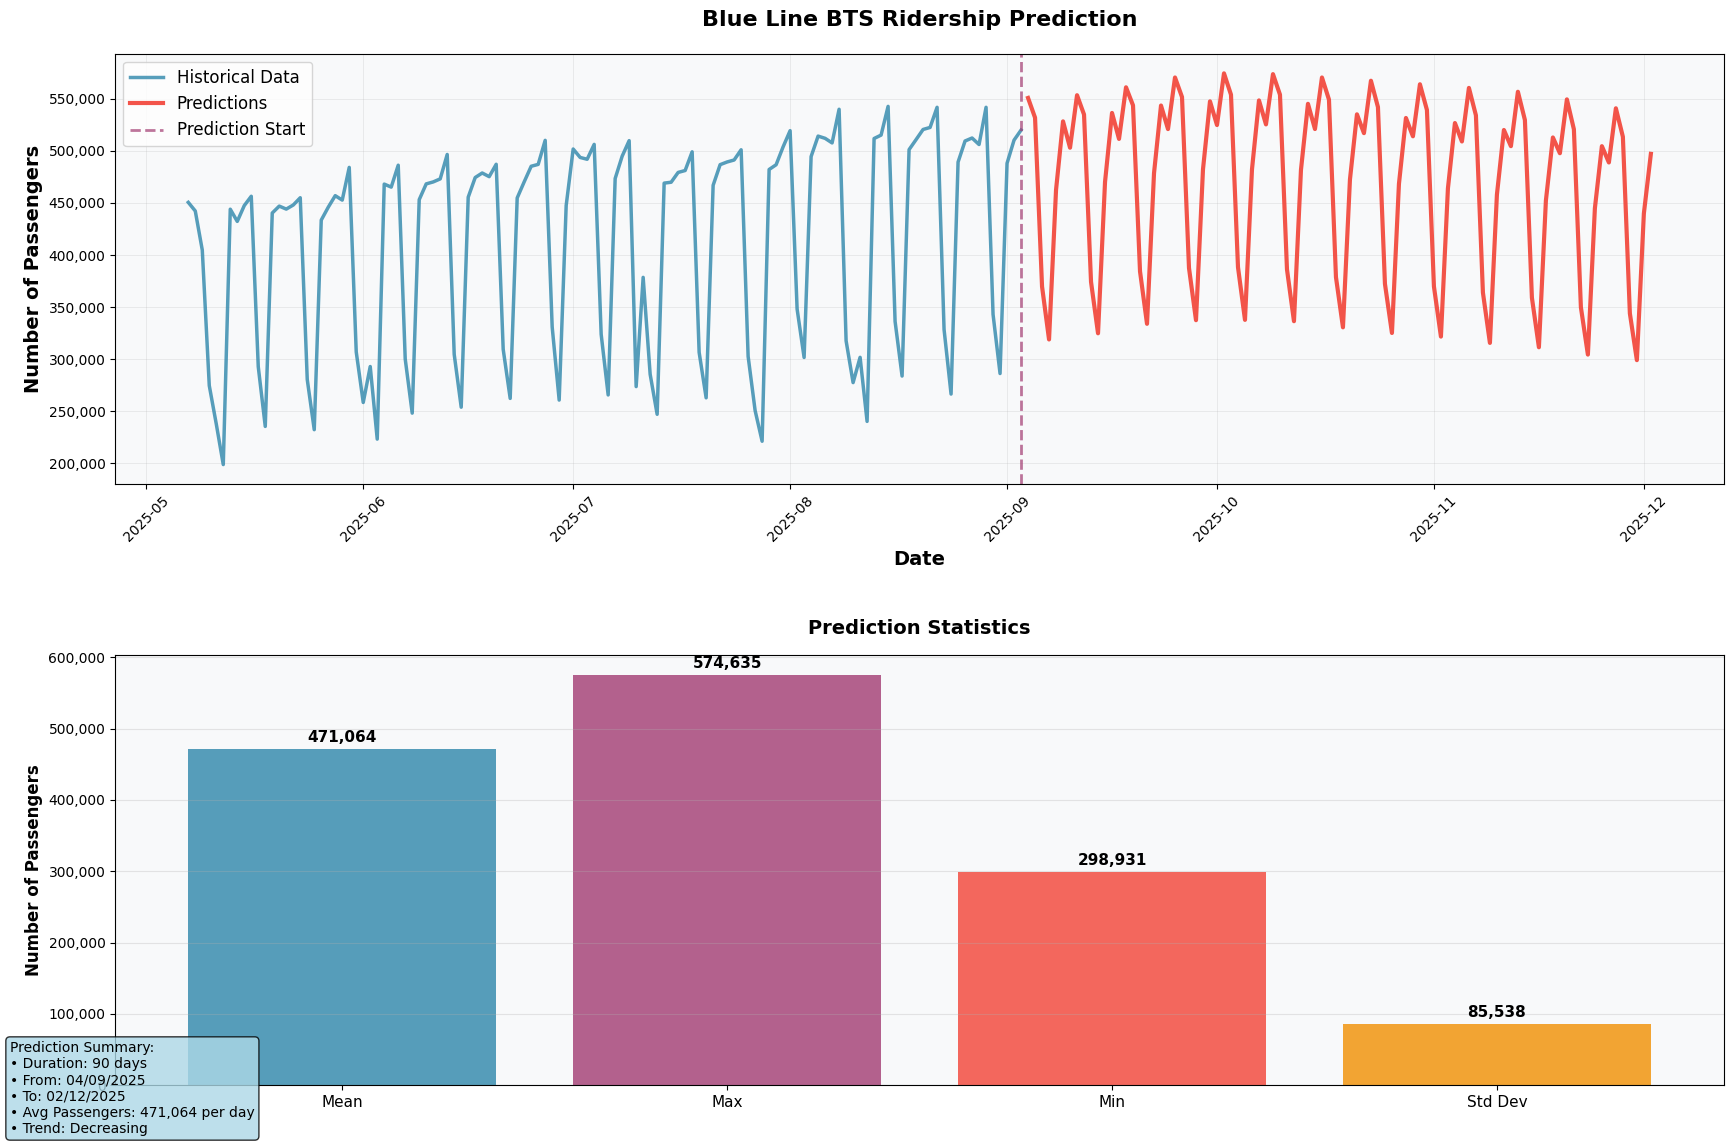

📊 BTS Blue Line Ridership Prediction Statistics
🗓️  Prediction Period: 90 days
📅 Start Date: 04 September 2025
📅 End Date: 02 December 2025
👥 Average Passengers: 471,064 per day
📈 Maximum: 574,635 on 02/10/2025
📉 Minimum: 298,931 on 30/11/2025
📊 Standard Deviation: 85,538
📋 Total Passengers: 42,395,723


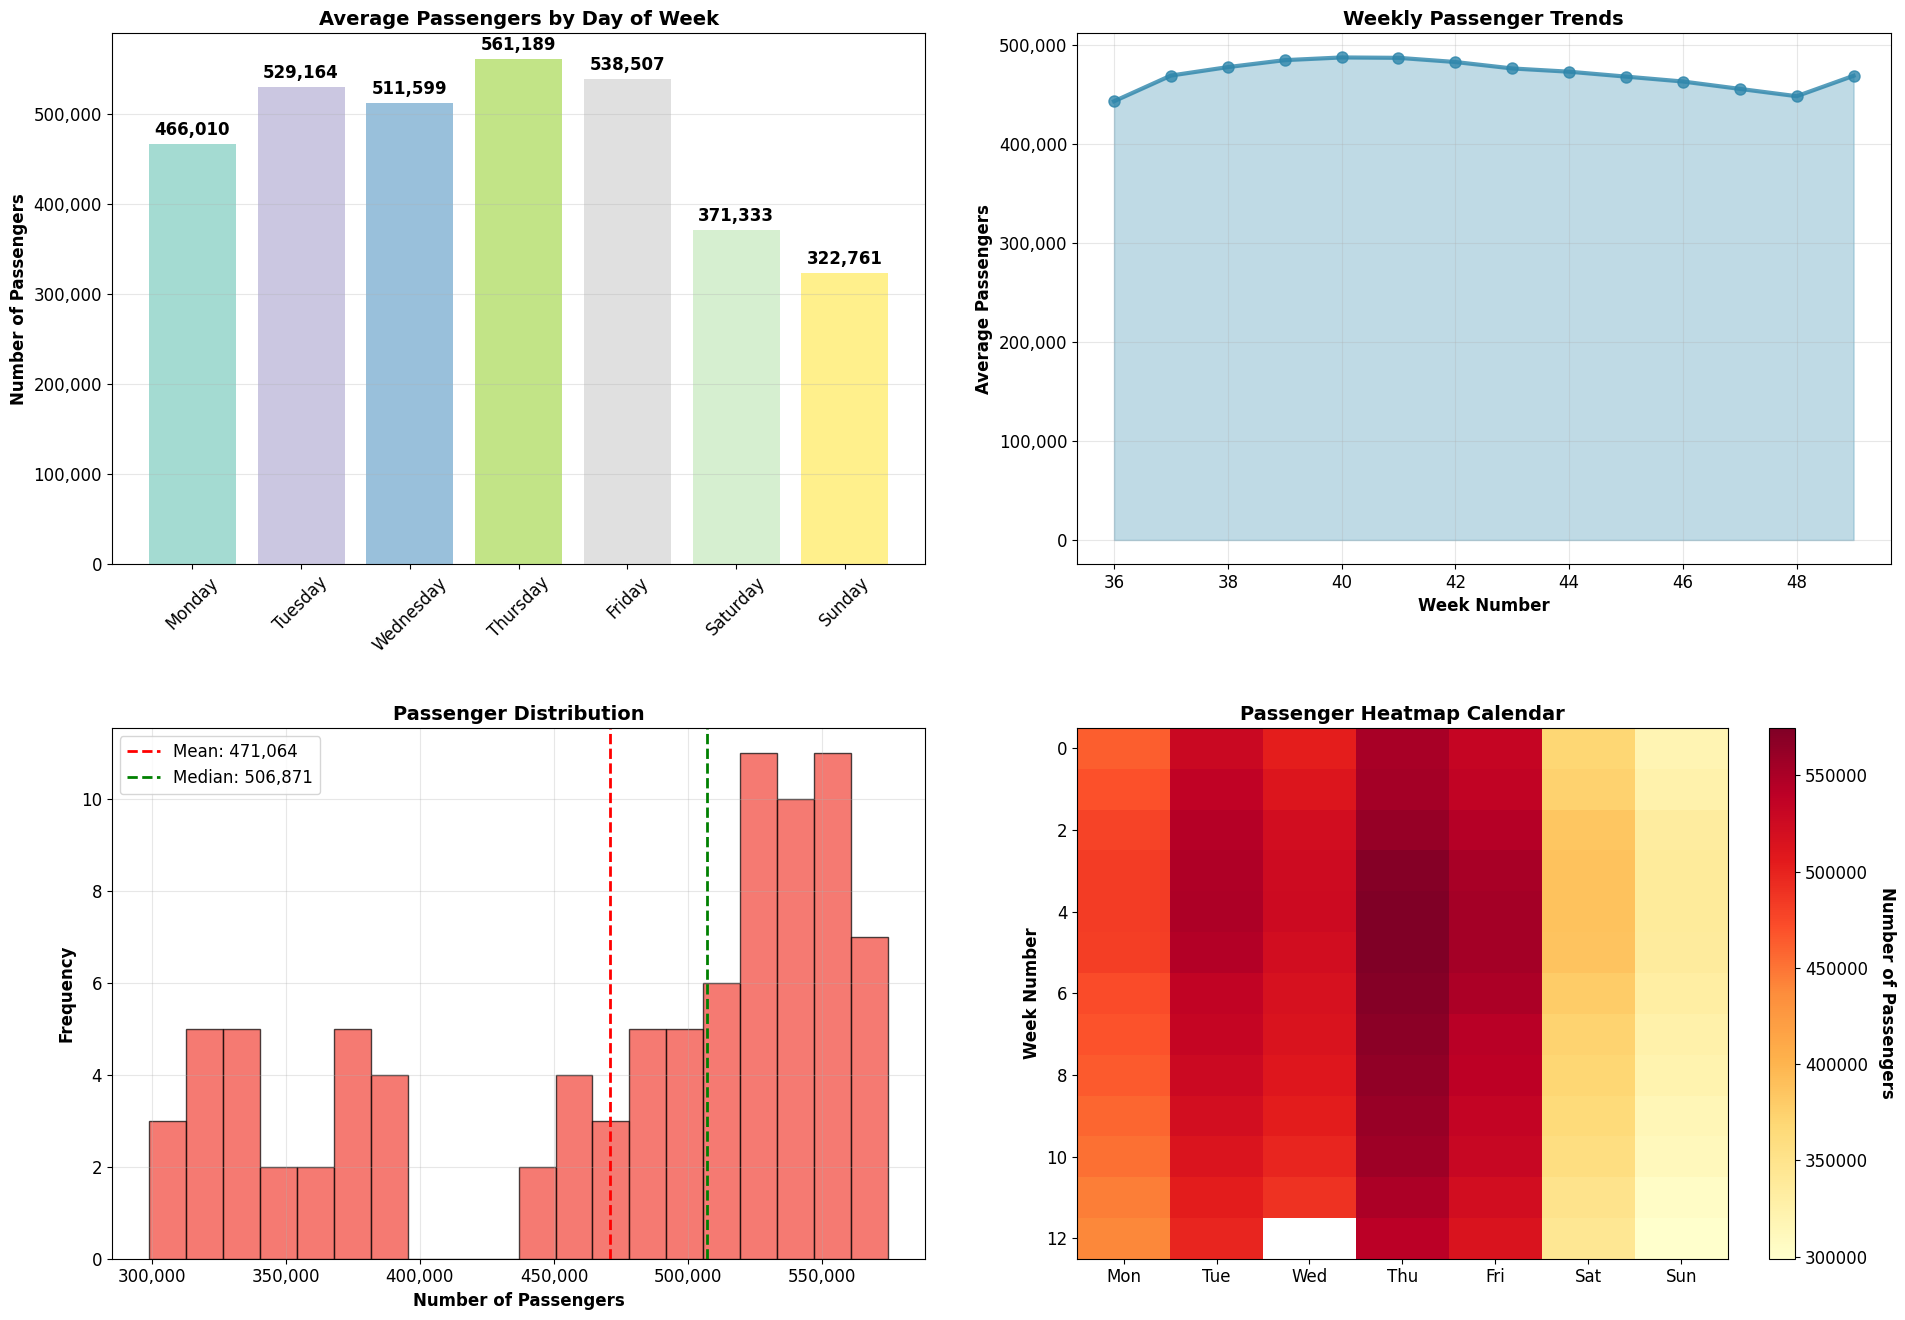

✅ Analysis Complete with English labels!


In [9]:
# ทดสอบการแสดงผลภาษาอังกฤษ (แก้ปัญหาสี่เหลี่ยม)
# ใช้โมเดลจากโฟลเดอร์ checkpoints
predictions = predict(model_path='checkpoints/best_model.pth', num_predictions=90)
if predictions is not None:
    visualize_predictions_en(predictions)
    df_analysis = analyze_daily_patterns_en(predictions)
    print("✅ Analysis Complete with English labels!")